In [69]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt

import math
import itertools
from itertools import product, combinations

import itertools
from itertools import combinations, product
import math
import time

import matplotlib.pyplot as plt
import numpy as np
import qutip as qt



# 1. Time Evolution
M Particle Number Manifold Hamiltonian Simulations

In [23]:
print(generate_basis_levels(4, 2, 3))

4 2 3
[(0, 0, 0, 2), (0, 0, 1, 1), (0, 0, 2, 0), (0, 1, 0, 1), (0, 1, 1, 0), (0, 2, 0, 0), (1, 0, 0, 1), (1, 0, 1, 0), (1, 1, 0, 0), (2, 0, 0, 0)]


In [24]:
def generate_triangle_ladder_single_particle_Hamiltonian(num_qubits, J_parallel, J_perp, detuning=None):
    
    if detuning is None:
        detuning = 0
        
    if isinstance(detuning, (int, float)):
        detuning = np.array([detuning]*num_qubits)
    
    H = np.zeros((num_qubits, num_qubits))
    
    for i in range(num_qubits):
        # qubit i is coupled to qubit i + 1 and qubit i + 2
        
        H[i,i] = detuning[i]
        
        if i < num_qubits - 1:
            H[i,i+1] = J_perp
            H[i+1,i] = np.conjugate(J_perp)
        
        if i < num_qubits - 2:
            H[i,i+2] = J_parallel
            H[i+2,i] = np.conjugate(J_parallel)
        
    return qt.Qobj(H)
    

def generate_basis(N, M):
    """Generate all bitstrings of length N with M ones."""
    basis = []
    for ones in combinations(range(N), M):
        state = [0] * N
        for i in ones:
            state[i] = 1
        basis.append(tuple(state))  # tuple makes it hashable
    return basis

def generate_basis_levels(N, M, num_levels):
    """Generate all bitstrings of length N with M ones."""
    basis = [state for state in product(range(num_levels), repeat=N) if sum(state) == M]
    print(N, M, num_levels)
    return basis

def construct_hamiltonian(N, M, single_particle_hamiltonian, detuning=None):
    """
    Construct the many-body Hamiltonian for hardcore bosons.
    
    Parameters:
      N: number of sites (qubits)
      M: number of particles
      adjacency: an N x N matrix (or a function) that gives the hopping connectivity.
      t: hopping amplitude (can be complex)
      
    Returns:
      H: the Hamiltonian matrix (numpy array) of shape (dim, dim)
    """
    
    if detuning is None:
        detuning = 0
        
    if isinstance(detuning, (int, float)):
        detuning = np.array([detuning]*num_qubits)
    
    # Generate basis and mapping to index
    basis = generate_basis(N, M)
    basis_to_index = {state: idx for idx, state in enumerate(basis)}
    dim = len(basis)
    H = np.zeros((dim, dim), dtype=complex)
    
    # Loop over basis states
    for state in basis:
        state_idx = basis_to_index[state]
        state_list = list(state)
        
        state_qobj = qt.Qobj([state[i] for i in range(len(state))])
#         basis_vector_conjugate = np.conjugate(basis_vector)
        
#         onsite_energy = qt.expect(single_particle_hamiltonian, state_qobj)
        onsite_energy = 0
        
        # For each occupied site
        for i in range(N):
            
            if state_list[i] == 1:
                # onsite energy
                onsite_energy += detuning[i]
                
                # For each possible hop to an empty site j
                for j in range(N):
                    if state_list[j] == 0 and single_particle_hamiltonian[i][j] != 0:
                        # Create new state by moving particle from i to j
                        new_state = state_list.copy()
                        new_state[i] = 0
                        new_state[j] = 1
                        new_state = tuple(new_state)
                        new_idx = basis_to_index[new_state]
                        
                        # Set matrix element
                        H[state_idx, new_idx] = single_particle_hamiltonian[i][j]
                        # For a Hermitian Hamiltonian, also set the symmetric element
                        H[new_idx, state_idx] = single_particle_hamiltonian[j][i]
    
        H[state_idx, state_idx] = onsite_energy
#         H[state_idx, state_idx] = 0
    
    # Diagonal onsite energies can be added here if needed.
    return qt.Qobj(H)


def construct_hamiltonian_more_levels(N, M, num_levels, U, single_particle_hamiltonian, detuning=None):
    """
    Construct the many-body Hamiltonian for hardcore bosons.
    
    Parameters:
      N: number of sites (qubits)
      M: number of particles
      adjacency: an N x N matrix (or a function) that gives the hopping connectivity.
      t: hopping amplitude (can be complex)
      
    Returns:
      H: the Hamiltonian matrix (numpy array) of shape (dim, dim)
    """
    
    if detuning is None:
        detuning = 0
        
    if isinstance(detuning, (int, float)):
        detuning = np.array([detuning]*num_qubits)
    
    # Generate basis and mapping to index
    basis = generate_basis_levels(N, M, num_levels)
    basis_to_index = {state: idx for idx, state in enumerate(basis)}
    dim = len(basis)
    H = np.zeros((dim, dim), dtype=complex)
    
    # Loop over basis states
    for state in basis:
        state_idx = basis_to_index[state]
        state_list = list(state)
        
        state_qobj = qt.Qobj([state[i] for i in range(len(state))])
#         basis_vector_conjugate = np.conjugate(basis_vector)
        
#         onsite_energy = qt.expect(single_particle_hamiltonian, state_qobj)
        onsite_energy = 0
        
        # For each occupied site
        for i in range(N):
            
            onsite_energy += U/2*state_list[i]*(state_list[i] -1)  
            
            if state_list[i] >= 1:
                # onsite energy
                onsite_energy += detuning[i]
                
                
                # For each possible hop to an empty site j
                for j in range(N):
                    if single_particle_hamiltonian[i][j] != 0:
                        # Create new state by moving particle from i to j
                        new_state = state_list.copy()
                        new_state[i] -= 1
                        new_state[j] += 1
                        new_state = tuple(new_state)
                        if new_state in basis_to_index:
                            new_idx = basis_to_index[new_state]
                        
                            # Set matrix element
                            H[state_idx, new_idx] = single_particle_hamiltonian[i][j] * np.sqrt((new_state[i]+1)*new_state[j])
                            # For a Hermitian Hamiltonian, also set the symmetric element
                            H[new_idx, state_idx] = single_particle_hamiltonian[j][i] * np.sqrt((new_state[i]+1)*new_state[j])
    
        H[state_idx, state_idx] = onsite_energy
#         H[state_idx, state_idx] = 0
    
    # Diagonal onsite energies can be added here if needed.
    return qt.Qobj(H)


In [25]:
single_particle_hamiltonian

Quantum object: dims=[[4], [4]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.          6.28318531 -6.28318531  0.        ]
 [ 6.28318531  0.          6.28318531 -6.28318531]
 [-6.28318531  6.28318531  0.          6.28318531]
 [ 0.         -6.28318531  6.28318531  0.        ]]

In [26]:
num_qubits = 4
num_particles = 2
num_levels = 2

print('basis')
print(generate_basis_levels(num_qubits, num_particles, num_levels))

num_states = math.comb(num_qubits, num_particles)

J_parallel = -1 * 2 *np.pi
J_perp = 1 * 2 *np.pi

U = -180 * 2 * np.pi

detuning = [0]*num_qubits

# adjacency = generate_triangle_adjacency(num_qubits)
single_particle_hamiltonian = generate_triangle_ladder_single_particle_Hamiltonian(num_qubits, J_parallel, J_perp, detuning)

# H = construct_hamiltonian(num_qubits, num_particles, single_particle_hamiltonian)
H = construct_hamiltonian_more_levels(num_qubits, num_particles, num_levels, U, single_particle_hamiltonian)

# print(generate_basis(num_qubits, num_particles))
print(H/2/np.pi)

basis
4 2 2
[(0, 0, 1, 1), (0, 1, 0, 1), (0, 1, 1, 0), (1, 0, 0, 1), (1, 0, 1, 0), (1, 1, 0, 0)]
4 2 2
Quantum object: dims=[[6], [6]], shape=(6, 6), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.  1. -1. -1.  0.  0.]
 [ 1.  0.  1.  1.  0.  0.]
 [-1.  1.  0.  0.  1. -1.]
 [-1.  1.  0.  0.  1. -1.]
 [ 0.  0.  1.  1.  0.  1.]
 [ 0.  0. -1. -1.  1.  0.]]


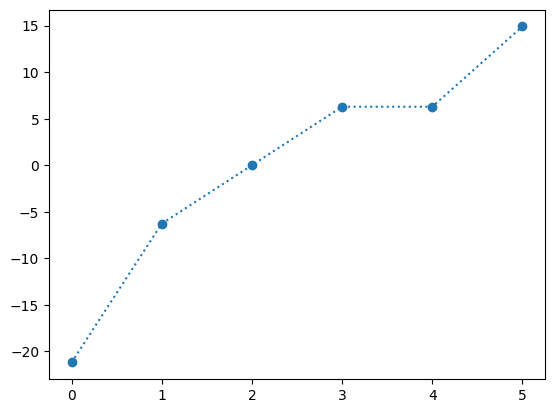

In [27]:
eigenenergies, eigenstates = H.eigenstates()

plt.plot(eigenenergies, linestyle=':', marker='o')
ground_state = eigenstates[0]

In [28]:
detuning = [2000*2*np.pi]*num_qubits

detuning[0] = 0
detuning[1] = 0
detuning[2] = 1000*2*np.pi
detuning[3] = 1000*2*np.pi

single_particle_hamiltonian_detuned = generate_triangle_ladder_single_particle_Hamiltonian(num_qubits, J_parallel, J_perp, detuning)

H_detuned = construct_hamiltonian(num_qubits, num_particles, single_particle_hamiltonian_detuned, detuning=detuning)
H_detuned = construct_hamiltonian_more_levels(num_qubits, num_particles, num_levels, U, single_particle_hamiltonian_detuned, detuning=detuning)

# print(H_detuned)

4 2 2


In [29]:
times = np.linspace(0, 0.2, 51)

psi0 = eigenstates[0]
# psi0 = qt.Qobj([0, 0, 1, 0, 0, 0])
# psi0 = qt.Qobj([0, 1])
# psi0 = qt.Qobj([0, 0, 1, 0, 0, 0])
# psi0 = 1/np.sqrt(2)*(qt.Qobj([0, 0, 1, 0, 0, 0]) + 1j*qt.Qobj([0, 0, 0, 0, 1, 0]))

# psi0 = 1/2*(qt.Qobj([1, 0, 0, 0]) + 1j*qt.Qobj([0, 1, 0, 0])) + 1/2*(qt.Qobj([0, 0, 1, 0]) + 1j*qt.Qobj([0, 0, 0, 1]))

# no correlations with 4 - 2 system
psi0 = 1/2*(qt.Qobj([0, 1, 0, 0, 0, 0]) + 1j*qt.Qobj([0, 0, 1, 0, 0, 0]) + 1j*qt.Qobj([0, 0, 0, 1, 0, 0]) - qt.Qobj([0, 0, 0, 0, 1, 0]))
# correlations with 4 - 2 system
positive_current_state = 1/2*(qt.Qobj([0, 1, 0, 0, 0, 0]) + 1j*qt.Qobj([0, 0, 1, 0, 0, 0]) + 1j*qt.Qobj([0, 0, 0, 1, 0, 0]) - qt.Qobj([0, 0, 0, 0, 1, 0]))
negative_current_state = 1/2*(qt.Qobj([0, 1, 0, 0, 0, 0]) - 1j*qt.Qobj([0, 0, 1, 0, 0, 0]) - 1j*qt.Qobj([0, 0, 0, 1, 0, 0]) - qt.Qobj([0, 0, 0, 0, 1, 0]))
counter_current_state = 1/np.sqrt(2)*(positive_current_state + negative_current_state)

psi0 = eigenstates[0]


result = qt.sesolve(H_detuned, psi0, times)

In [30]:
psi0

Quantum object: dims=[[6], [1]], shape=(6, 1), type='ket', dtype=Dense
Qobj data =
[[ 0.3830923 ]
 [-0.3830923 ]
 [ 0.45440135]
 [ 0.45440135]
 [-0.3830923 ]
 [ 0.3830923 ]]

In [31]:
print(generate_basis(num_qubits, num_particles))

[(1, 1, 0, 0), (1, 0, 1, 0), (1, 0, 0, 1), (0, 1, 1, 0), (0, 1, 0, 1), (0, 0, 1, 1)]


In [32]:
populations = np.zeros((num_qubits, len(times)))

basis = generate_basis(num_qubits, num_particles)
print(basis)
for i in range(len(times)):
    state_vector = result.states[i].data.to_array()[:,0]
    for j in range(len(basis)):
        amp = state_vector[j]
        for k in range(len(basis[j])):
            if basis[j][k] == 1:
                populations[k,i] += np.power(np.abs(amp), 2)

[(1, 1, 0, 0), (1, 0, 1, 0), (1, 0, 0, 1), (0, 1, 1, 0), (0, 1, 0, 1), (0, 0, 1, 1)]


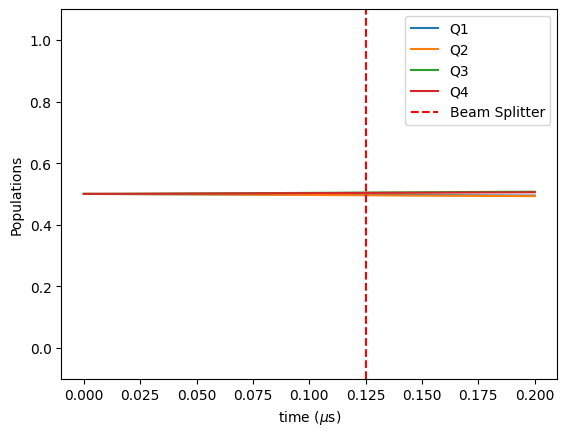

In [33]:
for i in range(populations.shape[0]):
    plt.plot(times, populations[i,:], label=f'Q{i+1}')
    
    
    
coupling = J_perp
beam_splitter_time = np.pi/(4*np.abs(coupling))

beam_splitter_index = np.round(np.argmin(np.abs(times - beam_splitter_time)))

plt.axvline(x=beam_splitter_time, color='r', linestyle='--', label='Beam Splitter')

    
plt.ylim(-0.1, 1.1)
    
plt.xlabel('time ($\mu$s)')
plt.ylabel('Populations')
plt.legend()
plt.show()

In [34]:
def current_expectation_value(i, j, left_basis_vector, right_basis_vector):
    value = 0

    right_basis_vector_copy = np.copy(right_basis_vector)
    right_basis_vector_copy[j] -= 1
    if all(right_basis_vector_copy >= 0) and all(right_basis_vector_copy <= 1):
        right_basis_vector_copy[i] += 1
        if all(right_basis_vector_copy >= 0) and all(right_basis_vector_copy <= 1):
            if np.array_equal(right_basis_vector_copy, left_basis_vector):
                value += 1j
                
    
    right_basis_vector_copy = np.copy(right_basis_vector)
    right_basis_vector_copy[i] -= 1
    if all(right_basis_vector_copy >= 0) and all(right_basis_vector_copy <= 1):
        right_basis_vector_copy[j] += 1
        if all(right_basis_vector_copy >= 0) and all(right_basis_vector_copy <= 1):
            if np.array_equal(right_basis_vector_copy, left_basis_vector):
                value -= 1j
            
    return value
    

In [35]:
left_basis_vector = np.array([1, 0, 1, 0])
right_basis_vector = np.array([0, 1, 1, 0])

print(current_expectation_value(0, 1, left_basis_vector, right_basis_vector))

1j


In [36]:
# print(result.states)

for i in range(len(result.states)):
    if i > 100:
        print(result.states[i].data.to_array())
    
#     for a in zip(result.states[i]):
#         print(a)
#     print()


In [37]:
### measure correlations

qubit_number_operators = np.zeros((num_qubits, num_states, num_states))

basis = generate_basis(num_qubits, num_particles)
for i in range(num_qubits):
    for j in range(len(basis)):
        basis_vector = basis[j]
        if basis_vector[i] == 1:
            qubit_number_operators[i,j,j] += 1
            
qubit_difference_operators = np.zeros((num_qubits, num_qubits, num_states, num_states))

for i in range(num_qubits):
    for j in range(num_qubits):
        qubit_difference_operators[i,j,:,:] = qubit_number_operators[i,:,:] - qubit_number_operators[j,:,:]

# print(basis)
# print(qubit_difference_operators[0,1,:,:])

                

In [38]:
Q1_Q2_difference = qubit_difference_operators[0,1,:,:]
Q3_Q4_difference = qubit_difference_operators[2,3,:,:]

Q2_Q3_difference = qubit_difference_operators[1,2,:,:]


Q1_Q3_difference = qubit_difference_operators[0,2,:,:]
Q2_Q4_difference = qubit_difference_operators[1,3,:,:]


Q1_Q2_difference_eigenvalues, Q1_Q2_difference_eigenvectors = np.linalg.eig(Q1_Q2_difference)


# print(Q1_Q2_difference)
# print(Q3_Q4_difference)
# print(Q1_Q2_difference_eigenvalues)
# print(Q1_Q2_difference_eigenvectors)

In [39]:
beam_splitter_state = result.states[beam_splitter_index]
beam_splitter_vector = beam_splitter_state.data.to_array()[:,0]


In [40]:
initial_state = psi0.data.to_array()

print_states = True
print_states = False
if print_states:
    print('initial_state')
    print(initial_state)

    print('beam splitter state')
    print(beam_splitter_vector)

In [41]:
current_expectation_Q1_Q2 = (np.conjugate(beam_splitter_vector) @ Q1_Q2_difference @ beam_splitter_vector).real
current_expectation_Q3_Q4 = (np.conjugate(beam_splitter_vector) @ Q3_Q4_difference @ beam_splitter_vector).real

current_correlation_Q1_Q2_Q3_Q4 = (np.conjugate(beam_splitter_vector) @ Q1_Q2_difference @ Q3_Q4_difference @ beam_splitter_vector).real

print(current_expectation_Q1_Q2)
print(current_expectation_Q3_Q4)
print(current_correlation_Q1_Q2_Q3_Q4)

0.00117109230242154
0.0011710923024252356
0.12004817229783683


# 2. Direct Current Correlation Measurement

### 2.1 Find desired eigenstate

In [42]:
def get_reduced_a_operator(num_qubits, num_particles, num_levels, qubit_index):
    
    reduced_basis = generate_basis_levels(num_qubits, num_particles, num_levels)
    full_basis = [bits for bits in product(range(num_levels), repeat=num_qubits)]
    
    reduced_a_operator_array = np.zeros((len(reduced_basis),len(reduced_basis)), dtype='complex')
    
    for i in range(len(reduced_basis)):
        reduced_basis_state_vector_left = list(reduced_basis[i])
        for j in range(len(reduced_basis)):
            reduced_basis_state_vector_right = list(reduced_basis[j])
            
#             new_state = 
            
        print(reduced_basis_state_vector_left)
    
#     for i in range(len(reduced_basis)):
#         reduced_basis_state = reduced_basis[i]
        
#         full_basis_index = full_basis.index(reduced_basis_state)
        
#         full_state[full_basis_index] = reduced_state[i]
    
#     return qt.Qobj(full_state, dims=[[num_levels] * num_qubits, [1]*num_qubits])

In [43]:
get_reduced_a_operator(num_qubits, num_particles, num_levels, 0)

4 2 2
[0, 0, 1, 1]
[0, 1, 0, 1]
[0, 1, 1, 0]
[1, 0, 0, 1]
[1, 0, 1, 0]
[1, 1, 0, 0]


In [47]:
num_levels = 2
num_qubits = 4
num_particles = 2

num_states = math.comb(num_qubits, num_particles)

J_parallel = 1 * 2 *np.pi
J_perp = 1 * 2 *np.pi

# 0: ground
eigenstate_index = -1

single_particle_hamiltonian = generate_triangle_ladder_single_particle_Hamiltonian(num_qubits, J_parallel, J_perp)

# H = construct_hamiltonian(num_qubits, num_particles, single_particle_hamiltonian)
H = construct_hamiltonian_more_levels(num_qubits, num_particles, num_levels, U, single_particle_hamiltonian)

4 2 2


In [51]:
H/2/np.pi

Quantum object: dims=[[6], [6]], shape=(6, 6), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 1. 1. 1. 0. 0.]
 [1. 0. 1. 1. 0. 0.]
 [1. 1. 0. 0. 1. 1.]
 [1. 1. 0. 0. 1. 1.]
 [0. 0. 1. 1. 0. 1.]
 [0. 0. 1. 1. 1. 0.]]

In [52]:
eigenvalues, eigenstates = H.eigenstates()

In [53]:
# custom psi0
reduced_psi0 = 1/2*(qt.Qobj([0, 1, 0, 0, 0, 0]) + 1j*qt.Qobj([0, 0, 1, 0, 0, 0]) + 1j*qt.Qobj([0, 0, 0, 1, 0, 0]) - qt.Qobj([0, 0, 0, 0, 1, 0]))
positive_current_state = 1/2*(qt.Qobj([0, 1, 0, 0, 0, 0]) + 1j*qt.Qobj([0, 0, 1, 0, 0, 0]) + 1j*qt.Qobj([0, 0, 0, 1, 0, 0]) - qt.Qobj([0, 0, 0, 0, 1, 0]))
negative_current_state = 1/2*(qt.Qobj([0, 1, 0, 0, 0, 0]) - 1j*qt.Qobj([0, 0, 1, 0, 0, 0]) - 1j*qt.Qobj([0, 0, 0, 1, 0, 0]) - qt.Qobj([0, 0, 0, 0, 1, 0]))
counter_current_state = 1/np.sqrt(2)*(positive_current_state + negative_current_state)
reduced_psi0 = positive_current_state

reduced_psi0 = eigenstates[eigenstate_index]

print('reduced psi0:')
reduced_psi0

reduced psi0:


Quantum object: dims=[[6], [1]], shape=(6, 1), type='ket', dtype=Dense
Qobj data =
[[-0.3830923 ]
 [-0.3830923 ]
 [-0.45440135]
 [-0.45440135]
 [-0.3830923 ]
 [-0.3830923 ]]

2 things to try,
full current operator on full matrix,
get reduced density matrix from reduced psi0 directly, instead of from full psi

# 3. Direct Current Correlation Measurement reduced density matrix

In [70]:
def convert_reduced_to_full_state(num_qubits, num_particles, num_levels, reduced_state):
    '''
    convert an N qubit state in the M particle to an N qubit state in 2^N space
    '''
    
    reduced_state_vector = reduced_state.data.to_array()
    
    reduced_basis = generate_basis_levels(num_qubits, num_particles, num_levels)
    full_basis = [bits for bits in product(range(num_levels), repeat=num_qubits)]
    
    full_state = np.zeros(num_levels**num_qubits, dtype='complex')
    
    for i in range(len(reduced_basis)):
        reduced_basis_state = reduced_basis[i]
        
        full_basis_index = full_basis.index(reduced_basis_state)
        
        full_state[full_basis_index] = reduced_state[i]
    
    return qt.Qobj(full_state, dims=[[num_levels] * num_qubits, [1]*num_qubits])

### 3.1 Find desired eigenstate

In [71]:
print(len(generate_basis_levels(num_qubits, num_particles, num_levels)))

4 2 2
6


In [102]:
num_levels = 2
num_qubits = 8
num_particles = 4

num_states = math.comb(num_qubits, num_particles)

J_parallel = 1 * 2*np.pi
J_perp = -1 * 2*np.pi
U = -180 *2*np.pi

# 0: ground
eigenstate_index = -1

single_particle_hamiltonian = generate_triangle_ladder_single_particle_Hamiltonian(num_qubits, J_parallel, J_perp)

# H = construct_hamiltonian(num_qubits, num_particles, single_particle_hamiltonian)
H = construct_hamiltonian_more_levels(num_qubits, num_particles, num_levels, U, single_particle_hamiltonian)

8 4 2


In [103]:
eigenvalues, eigenstates = H.eigenstates()

In [104]:
# custom psi0
reduced_psi0 = 1/2*(qt.Qobj([0, 1, 0, 0, 0, 0]) + 1j*qt.Qobj([0, 0, 1, 0, 0, 0]) + 1j*qt.Qobj([0, 0, 0, 1, 0, 0]) - qt.Qobj([0, 0, 0, 0, 1, 0]))
positive_current_state = 1/2*(qt.Qobj([0, 1, 0, 0, 0, 0]) + 1j*qt.Qobj([0, 0, 1, 0, 0, 0]) + 1j*qt.Qobj([0, 0, 0, 1, 0, 0]) - qt.Qobj([0, 0, 0, 0, 1, 0]))
negative_current_state = 1/2*(qt.Qobj([0, 1, 0, 0, 0, 0]) - 1j*qt.Qobj([0, 0, 1, 0, 0, 0]) - 1j*qt.Qobj([0, 0, 0, 1, 0, 0]) - qt.Qobj([0, 0, 0, 0, 1, 0]))
counter_current_state = 1/np.sqrt(2)*(positive_current_state + negative_current_state)
reduced_psi0 = positive_current_state

reduced_psi0 = eigenstates[eigenstate_index]

print('reduced psi0:')
reduced_psi0

reduced psi0:


Quantum object: dims=[[70], [1]], shape=(70, 1), type='ket', dtype=Dense
Qobj data =
[[ 0.02149182]
 [-0.03697808]
 [ 0.06593274]
 [-0.06857458]
 [ 0.06386441]
 [ 0.06593274]
 [-0.08595193]
 [ 0.10781522]
 [-0.09722724]
 [ 0.13330341]
 [-0.13046512]
 [ 0.14453207]
 [ 0.13972185]
 [-0.11794797]
 [ 0.10239122]
 [-0.06857458]
 [ 0.10781522]
 [-0.13367866]
 [ 0.12546365]
 [-0.13046512]
 [ 0.1274966 ]
 [-0.14401361]
 [-0.15950004]
 [ 0.13923441]
 [-0.11794797]
 [ 0.13972185]
 [-0.15950004]
 [ 0.18157203]
 [ 0.16468495]
 [-0.14401361]
 [ 0.14453207]
 [-0.11825936]
 [ 0.12546365]
 [-0.09722724]
 [ 0.06386441]
 [ 0.06386441]
 [-0.09722724]
 [ 0.12546365]
 [-0.11825936]
 [ 0.14453207]
 [-0.14401361]
 [ 0.16468495]
 [ 0.18157203]
 [-0.15950004]
 [ 0.13972185]
 [-0.11794797]
 [ 0.13923441]
 [-0.15950004]
 [-0.14401361]
 [ 0.1274966 ]
 [-0.13046512]
 [ 0.12546365]
 [-0.13367866]
 [ 0.10781522]
 [-0.06857458]
 [ 0.10239122]
 [-0.11794797]
 [ 0.13972185]
 [ 0.14453207]
 [-0.13046512]
 [ 0.13330341]


In [105]:
full_psi0 = convert_reduced_to_full_state(num_qubits, num_particles, num_levels, reduced_psi0)
print('full psi0')
full_psi0

8 4 2
full psi0


Quantum object: dims=[[2, 2, 2, 2, 2, 2, 2, 2], [1, 1, 1, 1, 1, 1, 1, 1]], shape=(256, 1), type='ket', dtype=Dense
Qobj data =
[[ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.02149182]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [-0.03697808]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.06593274]
 [ 0.        ]
 [-0.06857458]
 [ 0.06386441]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.06593274]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [-0.08595193]
 [ 0.        ]
 [ 0.10781522]
 [-0.09722724]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.13330341]
 [ 0.        ]
 [-0.13046512]
 [ 0.14453207]
 [ 0.        ]
 [ 0.        ]
 [ 0.13972185]
 [-

### 3.2 Create current operators

In [106]:
a = qt.destroy(num_levels)
a1 = qt.tensor(a, qt.qeye(num_levels))
a2 = qt.tensor(qt.qeye(num_levels), a)


current_operator = lambda J: 1j*(J*a1.dag()*a2 - np.conjugate(J)*a2.dag()*a1)
current_operator(1)

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dia, isherm=True
Qobj data =
[[ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -0.-1.j  0.+0.j]
 [ 0.+0.j  0.+1.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]]

In [107]:
### 4Q composite state operators

current_operator_4Q_1 = lambda J: qt.tensor(current_operator(J), qt.tensor(qt.qeye(num_levels), qt.qeye(num_levels)))
current_operator_4Q_2 = lambda J: qt.tensor(qt.tensor(qt.qeye(num_levels), qt.qeye(num_levels)), current_operator(J))

In [108]:
### 3Q composite state operators

a_3Q_1 = qt.tensor(a, qt.qeye(num_levels), qt.qeye(num_levels))
a_3Q_2 = qt.tensor(qt.qeye(num_levels), a, qt.qeye(num_levels))
a_3Q_3 = qt.tensor(qt.qeye(num_levels), qt.qeye(num_levels), a)

current_operator_3Q_12 = lambda J: 1j*(J*a_3Q_1.dag()*a_3Q_2 - np.conjugate(J)*a_3Q_2.dag()*a_3Q_1)
current_operator_3Q_23 = lambda J: 1j*(J*a_3Q_2.dag()*a_3Q_3 - np.conjugate(J)*a_3Q_3.dag()*a_3Q_2)
current_operator_3Q_13 = lambda J: 1j*(J*a_3Q_1.dag()*a_3Q_3 - np.conjugate(J)*a_3Q_3.dag()*a_3Q_1)

### 3.3 Calculate Correlations

In [109]:
def calculate_current(density_matrix, J):
    return (density_matrix * current_operator(J)).tr()

def calculate_current_correlation(density_matrix, J_12, J_34):
    return (density_matrix * current_operator_4Q_1(J_12) * current_operator_4Q_2(J_34)).tr()

def calculate_3Q_current_correlation(density_matrix, J_12, J_13, J_23):
    '''
    in the case of the 3Q system, with edges that share a vertex, the current operator and composite state are different
    '''
    
    current_correlation_12_23 = (density_matrix * current_operator_3Q_12(J_12) * current_operator_3Q_23(J_23)).tr()
    current_correlation_12_13 = (density_matrix * current_operator_3Q_12(J_12) * current_operator_3Q_13(J_13)).tr()
    current_correlation_23_13 = (density_matrix * current_operator_3Q_23(J_23) * current_operator_3Q_13(J_13)).tr()
    
    return current_correlation_12_23, current_correlation_12_13, current_correlation_23_13

In [110]:
rho_1 = full_psi0.ptrace([0, 1])
rho_2 = full_psi0.ptrace([2, 3])

rho_1

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.147368    0.          0.          0.        ]
 [ 0.          0.352632   -0.35010835  0.        ]
 [ 0.         -0.35010835  0.352632    0.        ]
 [ 0.          0.          0.          0.147368  ]]

In [111]:
print(calculate_current(rho_1, 1))

0j


In [112]:
calculate_current_correlation(qt.tensor(rho_1, rho_2), 1, 1)

0j

In [113]:
single_particle_hamiltonian

Quantum object: dims=[[8], [8]], shape=(8, 8), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.         -6.28318531  6.28318531  0.          0.          0.
   0.          0.        ]
 [-6.28318531  0.         -6.28318531  6.28318531  0.          0.
   0.          0.        ]
 [ 6.28318531 -6.28318531  0.         -6.28318531  6.28318531  0.
   0.          0.        ]
 [ 0.          6.28318531 -6.28318531  0.         -6.28318531  6.28318531
   0.          0.        ]
 [ 0.          0.          6.28318531 -6.28318531  0.         -6.28318531
   6.28318531  0.        ]
 [ 0.          0.          0.          6.28318531 -6.28318531  0.
  -6.28318531  6.28318531]
 [ 0.          0.          0.          0.          6.28318531 -6.28318531
   0.         -6.28318531]
 [ 0.          0.          0.          0.          0.          6.28318531
  -6.28318531  0.        ]]

In [114]:
# 1 indexed
base_qubit_pair = (1, 2) 

all_qubits = list(range(1, num_qubits+1))
all_qubit_pairs = list(itertools.combinations(all_qubits, 2))

currents = {}
current_correlations = {}

# calculate currents
print('calculating currents')
for i in range(len(all_qubit_pairs)):
    
    q_1, q_2 = all_qubit_pairs[i]
    
    coupling = single_particle_hamiltonian[q_1 - 1, q_2 - 1]
    if coupling == 0:
            continue
    print(q_1, q_2)
    
    
    rho = full_psi0.ptrace([q_1-1, q_2-1])
    
    currents[q_1, q_2] = calculate_current(rho, coupling).real/2/np.pi
    
    
    
print('calculating current correlations')
# calculate correlations
for i in range(len(all_qubit_pairs)):
    q_11, q_12 = all_qubit_pairs[i]
    coupling_1 = single_particle_hamiltonian[q_11 - 1, q_12 - 1]
    
    print(q_11, q_12)
    
    for j in range(i+1, len(all_qubit_pairs)):
        q_21, q_22 = all_qubit_pairs[j]        
        coupling_2 = single_particle_hamiltonian[q_21 - 1, q_22 - 1]
        
        if coupling_1 == 0 or coupling_2 == 0:
            continue
        
        if q_21 in [q_11, q_12] or q_22 in [q_11, q_12]:
            # need to do 3Q system
            rho = full_psi0.ptrace(list(set([q_11-1, q_12-1, q_21-1, q_22-1])))
            # q_11, q_12 should always be leg 12
                # unless q_12 and q_22 are the same
            # if q_11 and q_21 are the same, then q_21 - q_22 should be leg 13
            # if q_12 and q_21 are the same, then q_21 - q_22 should be leg 23
            # if q_12 and q_22 are the same, then q_11 - q_12 should be leg 13 and q_21 - q_22 should be leg 23
            if q_11 == q_21:
                current_correlation_12_23, current_correlation_12_13, current_correlation_23_13 = calculate_3Q_current_correlation(rho, coupling_1, coupling_2, 0)
                current_correlations[((q_11, q_12),(q_21, q_22))] = current_correlation_12_13.real/2/np.pi/2/np.pi
            elif q_12 == q_21:
                current_correlation_12_23, current_correlation_12_13, current_correlation_23_13 = calculate_3Q_current_correlation(rho, coupling_1, 0, coupling_2)
                current_correlations[((q_11, q_12),(q_21, q_22))] = current_correlation_12_23.real/2/np.pi/2/np.pi
            elif q_12 == q_22:
                current_correlation_12_23, current_correlation_12_13, current_correlation_23_13 = calculate_3Q_current_correlation(rho, 0, coupling_1, coupling_2)
                current_correlations[((q_11, q_12),(q_21, q_22))] = current_correlation_23_13.real/2/np.pi/2/np.pi
            else:
                print('other case')
                print((q_11, q_12),(q_21, q_22))
        else:
            rho = full_psi0.ptrace([q_11-1, q_12-1, q_21-1, q_22-1])
            current_correlations[((q_11, q_12),(q_21, q_22))] = calculate_current_correlation(rho, coupling_1, coupling_2).real/2/np.pi/2/np.pi
        
        

calculating currents
1 2
1 3
2 3
2 4
3 4
3 5
4 5
4 6
5 6
5 7
6 7
6 8
7 8
calculating current correlations
1 2
1 3
1 4
1 5
1 6
1 7
1 8
2 3
2 4
2 5
2 6
2 7
2 8
3 4
3 5
3 6
3 7
3 8
4 5
4 6
4 7
4 8
5 6
5 7
5 8
6 7
6 8
7 8


In [115]:
currents

{(1, 2): 0.0,
 (1, 3): 0.0,
 (2, 3): 0.0,
 (2, 4): 0.0,
 (3, 4): 0.0,
 (3, 5): 0.0,
 (4, 5): 0.0,
 (4, 6): 0.0,
 (5, 6): 0.0,
 (5, 7): 0.0,
 (6, 7): 0.0,
 (6, 8): 0.0,
 (7, 8): 0.0}

In [116]:
current_correlations

{((1, 2), (1, 3)): 0.2920481949651053,
 ((1, 2), (2, 3)): -0.3158774975735611,
 ((1, 2), (2, 4)): -0.260774979937432,
 ((1, 2), (3, 4)): 0.06782583294440456,
 ((1, 2), (3, 5)): 0.014912417111893343,
 ((1, 2), (4, 5)): -0.039137480520201745,
 ((1, 2), (4, 6)): -0.03754272836823705,
 ((1, 2), (5, 6)): -7.064475097078998e-06,
 ((1, 2), (5, 7)): -0.005599381144061246,
 ((1, 2), (6, 7)): -0.006129889242961909,
 ((1, 2), (6, 8)): -0.00836927726429329,
 ((1, 2), (7, 8)): -0.0019346626791046093,
 ((1, 3), (2, 3)): 0.3501083515744134,
 ((1, 3), (2, 4)): 0.06782583294440456,
 ((1, 3), (3, 4)): -0.260774979937432,
 ((1, 3), (3, 5)): -0.23257760581057588,
 ((1, 3), (4, 5)): 0.00984035679302087,
 ((1, 3), (4, 6)): -0.01848625723436889,
 ((1, 3), (5, 6)): -0.03246709000215406,
 ((1, 3), (5, 7)): -0.034913934891728775,
 ((1, 3), (6, 7)): -0.003163531427481736,
 ((1, 3), (6, 8)): -0.010823373267098403,
 ((1, 3), (7, 8)): -0.008369277264293335,
 ((2, 3), (2, 4)): 0.2995748204861167,
 ((2, 3), (3, 4)): 

In [999]:
print('odd correlations, should be negative')

base_pair = (1, 2)
print(all_qubits)
for qubit_pair in combinations(all_qubits, 2):
    if (base_pair[0] - qubit_pair[0]) % 2 == 1 and qubit_pair[1] == qubit_pair[0] + 1:
        correlation_pair = (base_pair, qubit_pair)
        if correlation_pair in current_correlations:
            print(f'{correlation_pair}: {current_correlations[correlation_pair]}')
        else:
            correlation_pair = (qubit_pair, base_pair)
            if correlation_pair in current_correlations:
                print(f'{correlation_pair}: {current_correlations[correlation_pair]}')

odd correlations, should be negative
[1, 2, 3, 4, 5, 6, 7, 8]
((1, 2), (2, 3)): 29.670423079248124
((1, 2), (4, 5)): 14.22541308743041
((1, 2), (6, 7)): 5.881896189150824


In [ ]:
((1, 2), (2, 3)): 17.86409335396236
((1, 2), (4, 5)): 8.47711323295295
((1, 2), (6, 7)): 7.529773766553935

print('even correlations, should be positive')

In [978]:
print('even correlations, should be positive')

base_pair = (1, 2)
print(all_qubits)
for qubit_pair in combinations(all_qubits, 2):
    if (base_pair[0] - qubit_pair[0]) % 2 == 0 and qubit_pair[1] == qubit_pair[0] + 1:
        correlation_pair = (base_pair, qubit_pair)
        if correlation_pair in current_correlations:
            print(f'{correlation_pair}: {current_correlations[correlation_pair]}')
        else:
            correlation_pair = (qubit_pair, base_pair)
            if correlation_pair in current_correlations:
                print(f'{correlation_pair}: {current_correlations[correlation_pair]}')

even correlations, should be positive
[1, 2, 3, 4, 5, 6, 7, 8]
((1, 2), (3, 4)): 6.782583294440461
((1, 2), (5, 6)): -0.0007064475096974608
((1, 2), (7, 8)): -0.193466267910455


In [ ]:
((1, 2), (3, 4)): 0.9523106303019248
((1, 2), (5, 6)): 0.13821799443074043
((1, 2), (7, 8)): -0.014169995642676509
​